# Optimal Transport with Linear Programming

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/gpeyre/ot4ml/blob/main/python/1-linprog.ipynb)

This numerical tours details how to solve the discrete optimal transport
problem (in the case of measures that are sums of Diracs) using linear
programming.

You need to install [CVXPY](https://www.cvxpy.org/). _Warning:_ seems to not be working on Python 3.7, use rather 3.6.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp

(CVXPY) May 25 09:33:56 AM: Encountered unexpected exception importing solver SCS:
ImportError("dlopen(/Users/gpeyre/miniconda3/lib/python3.10/site-packages/_scs_direct.cpython-310-darwin.so, 0x0002): Library not loaded: @rpath/liblapack.3.dylib\n  Referenced from: <EA245032-41C7-30EA-BA1A-C55492696949> /Users/gpeyre/miniconda3/lib/python3.10/site-packages/_scs_direct.cpython-310-darwin.so\n  Reason: tried: '/Users/gpeyre/miniconda3/lib/python3.10/site-packages/../../liblapack.3.dylib' (no such file), '/Users/gpeyre/miniconda3/lib/python3.10/site-packages/../../liblapack.3.dylib' (no such file), '/Users/gpeyre/miniconda3/bin/../lib/liblapack.3.dylib' (no such file), '/Users/gpeyre/miniconda3/bin/../lib/liblapack.3.dylib' (no such file), '/usr/local/lib/liblapack.3.dylib' (no such file), '/usr/lib/liblapack.3.dylib' (no such file, not in dyld cache)")


Optimal Transport of Discrete Distributions
------------------------------------------

We consider two discrete distributions
$$ 
\alpha = \sum_{i=1}^n a_i \delta_{x_i} \quad \text{and} \quad 
\beta = \sum_{j=1}^m b_j \delta_{y_j}.
$$

where $n, m$ are the number of points, $\delta_x$ is the Dirac at
location $x \in \mathbb{R}^d$, and $(x_i)_i$, $(y_j)_j$ are the positions of the Diracs in $\mathbb{R}^d$.

Dimensions $(n,m)$ of the coulds.

In [46]:
n = 60
m = 80

Generate the point clouds $X=(x_i)_i$ and $Y=(y_j)_j$.

In [47]:
gauss = lambda q,a,c: a*np.random.randn(2, q) + np.transpose(np.tile(c, (q,1)))
X = np.random.randn(2,n)*.3
Y = np.hstack((gauss(int(m/2),.5,[0,1.6]),np.hstack((gauss(int(m/4),.3,[-1,-1]),gauss(int(m/4),.3,[1,-1])))))

Generate the weights $a,b$.

In [48]:
normalize = lambda a: a/np.sum(a)
a = normalize(np.random.rand(n, 1))
b = normalize(np.random.rand(m, 1))

Helper function for display of clouds.

In [49]:
myplot = lambda x,y,ms,col: plt.scatter(x,y, s=ms*20, edgecolors="k", c=col, linewidths=2)

Display the point clouds.
The size of each dot is proportional to its probability density weight.

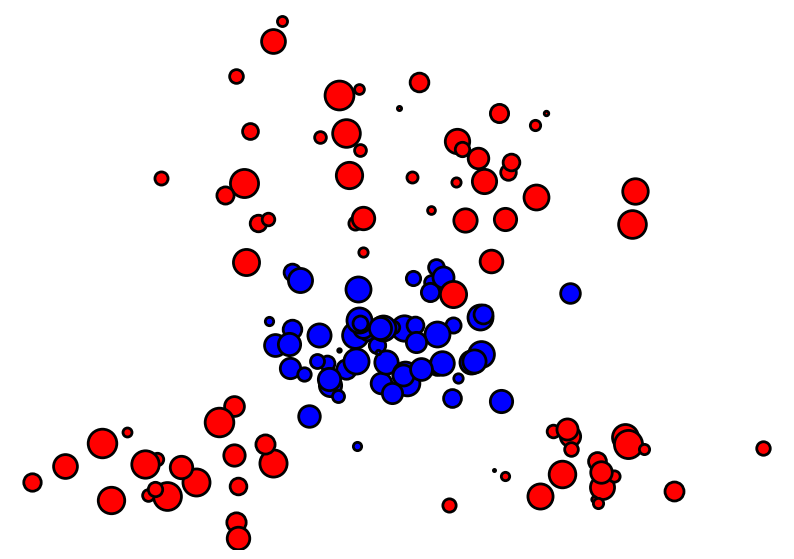

In [50]:
plt.figure(figsize = (10,7))
plt.axis("off")
for i in range(len(a)):
    myplot(X[0,i], X[1,i], a[i]*len(a)*10, 'b')
for j in range(len(b)):
    myplot(Y[0,j], Y[1,j], b[j]*len(b)*10, 'r')
plt.xlim(np.min(Y[0,:])-.1,np.max(Y[0,:])+.1)
plt.ylim(np.min(Y[1,:])-.1,np.max(Y[1,:])+.1)
plt.show()

Compute the cost matrix $C_{i,j} := \|x_i-x_j\|^2$.

In [51]:
def distmat(x,y):
    return np.sum(x**2,0)[:,None] + np.sum(y**2,0)[None,:] - 2*x.transpose().dot(y)
C = distmat(X,Y)

Define the optimiztion variable $P$.

In [52]:
P = cp.Variable((n,m))

Define the set of discrete couplings between $\alpha$ and $\beta$ as
$$
U(a, b) := \left\{ P \in \mathbb{R}_+^{n \times m} \;\middle|\;
\forall i, \sum_j P_{i,j} = a_i, \quad
\forall j, \sum_i P_{i,j} = b_j \right\}.
$$

In [53]:
constraints = [
    P >= 0,
    cp.sum(P, axis=1, keepdims=True) == a,  # Row sums match a
    cp.sum(P, axis=0, keepdims=True).T == b  # Column sums match b
]

The Kantorovich formulation of optimal transport reads
$$
    P^\star \in \underset{P \in U(a, b)}{\arg\min} \sum_{i,j} P_{i,j} C_{i,j}.
$$

In [54]:
objective = cp.Minimize( cp.sum(cp.multiply(P,C)) )
prob = cp.Problem(objective, constraints)
result = prob.solve()

An optimal coupling $P^\star$ can be shown to be a sparse matrix
with less than $n+m-1$ non zero entries. An entry $P_{i,j}^\star \neq 0$
should be understood as a link between $x_{i}$
and $y_{j}$ where an amount of mass equal to $P_{i,j}^\star$ is transfered.

Check that the number of non-zero entries in $P^\star$ is $n+m-1$. Beware that we are using an interior point method here, so that entries of $P^\star$ are nevery exactly 0.

In [55]:
print("Number of non-zero: %d (n + m-1 = %d)" %(len(P.value[P.value>1e-5]), n + m-1))

Number of non-zero: 139 (n + m-1 = 139)


Display the solution coupling.

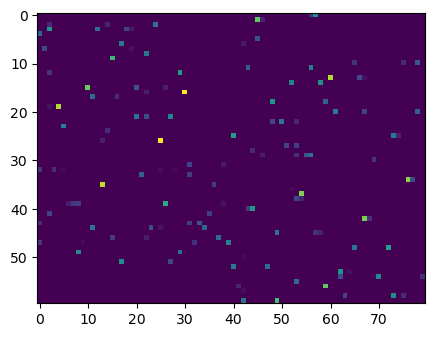

In [56]:
plt.figure(figsize = (5,5))
plt.imshow(P.value);

Display the connexion defined by the optimal coupling.

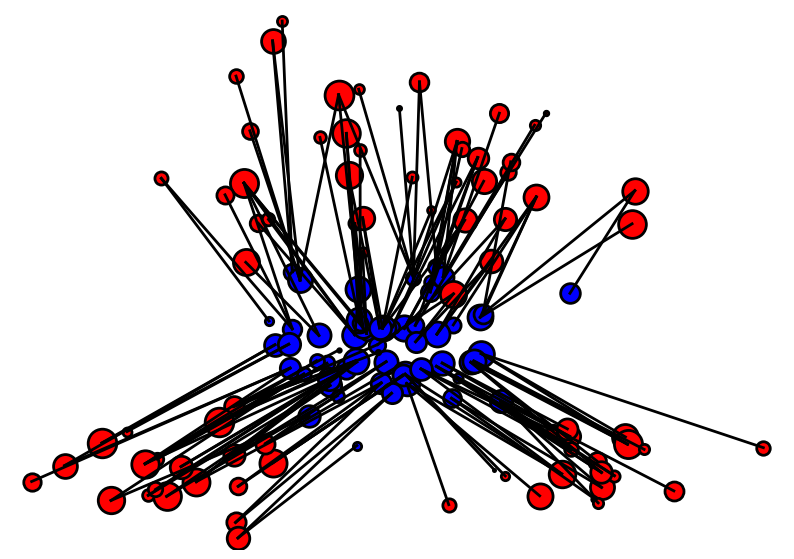

In [57]:
I,J = np.nonzero(P.value>1e-5)
plt.figure(figsize = (10,7))
plt.axis('off')
for k in range(len(I)):
    h = plt.plot(np.hstack((X[0,I[k]],Y[0,J[k]])),np.hstack(([X[1,I[k]], Y[1,J[k]]])),'k', lw = 2)
for i in range(len(a)):
    myplot(X[0,i], X[1,i], a[i]*len(a)*10, 'b')
for j in range(len(b)):
    myplot(Y[0,j], Y[1,j], b[j]*len(b)*10, 'r')
plt.xlim(np.min(Y[0,:])-.1,np.max(Y[0,:])+.1)
plt.ylim(np.min(Y[1,:])-.1,np.max(Y[1,:])+.1)
plt.show()

Displacement Interpolation
--------------------------
For any $t \in [0,1]$, one can define a distribution $\mu_t$ such that the map $t \mapsto \mu_t$ describes a geodesic in the Wasserstein space.

Since the $W_2$ distance is a geodesic distance, this geodesic path solves the following variational problem:
$$
\mu_t = \underset{\mu}{\arg\min} \, (1 - t) W_2(\alpha, \mu)^2 + t W_2(\beta, \mu)^2.
$$

This can be understood as a generalization of the classical Euclidean barycenter to the barycenter of probability distributions. Indeed, in the special case where $\alpha = \delta_x$ and $\beta = \delta_y$, one obtains $\mu_t = \delta_{x_t}$ with
$$
x_t = (1 - t)x + t y.
$$

Once the optimal coupling $P^\star$ has been computed, the interpolated distribution is given by
$$
\mu_t = \sum_{i,j} P^\star_{i,j} \, \delta_{(1 - t)x_i + t y_j}.
$$

Find the $i,j$ with non-zero $P_{i,j}^\star$.

In [58]:
I,J = np.nonzero(P.value>1e-5)
Pij = P.value[I,J]

Display the evolution of $\mu_t$ for a varying value of $t \in [0,1]$.

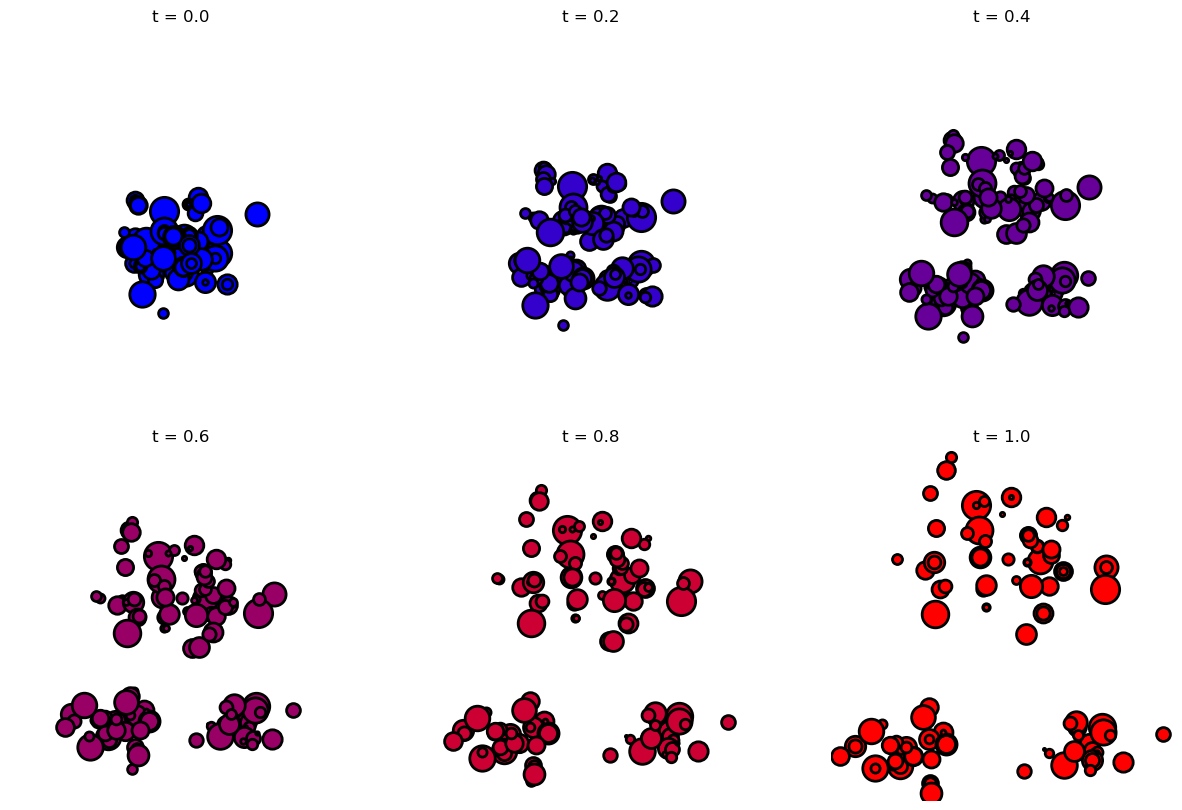

In [59]:
plt.figure(figsize =(15,10))
tlist = np.linspace(0, 1, 6)
for i in range(len(tlist)):
    t = tlist[i]
    Xt = (1-t)*X[:,I] + t*Y[:,J]
    plt.subplot(2,3,i+1)
    plt.axis("off")
    for j in range(len(Pij)):
        myplot(Xt[0,j],Xt[1,j],Pij[j]*len(Pij)*6,[[t,0,1-t]])
    plt.title("t = %.1f" %t) 
    plt.xlim(np.min(Y[0,:])-.1,np.max(Y[0,:])+.1)
    plt.ylim(np.min(Y[1,:])-.1,np.max(Y[1,:])+.1)
plt.show()

Optimal Assignement
-------------------
In the case where $n = m$ and the weights are uniform, i.e., $a_i = 1/n$ and $b_j = 1/n$, one can show that there exists at least one optimal transport coupling that is a permutation matrix. This property arises from the fact that the extremal points of the transport polytope $U(1, 1)$ are permutation matrices.

This means there exists an optimal permutation $\sigma^\star \in \Sigma_n$ such that
$$
P^\star_{i,j} =
\begin{cases}
1 & \text{if } j = \sigma^\star(i), \\
0 & \text{otherwise}.
\end{cases}
$$

Here, $\Sigma_n$ denotes the set of all permutations (bijections) of $\{1, \ldots, n\}$.

This permutation solves the so-called *optimal assignment problem*:
$$
\sigma^\star \in \underset{\sigma \in \Sigma_n}{\arg\min}
\sum_{i=1}^n C_{i, \sigma(i)}.
$$

Use the same number of points.

In [60]:
n = 40
m = n

Compute points clouds.

In [61]:
X = np.random.randn(2,n)*.3
Y = np.hstack((gauss(int(m/2),.5,[0,1.6]),np.hstack((gauss(int(m/4),.3,[-1,-1]),gauss(int(m/4),.3,[1,-1])))))

Constant distributions.

In [62]:
a = np.ones([n,1])/n
b = a

Compute the weight matrix $ (C_{i,j})_{i,j}. $

In [63]:
C = distmat(X,Y)

Display the coulds.

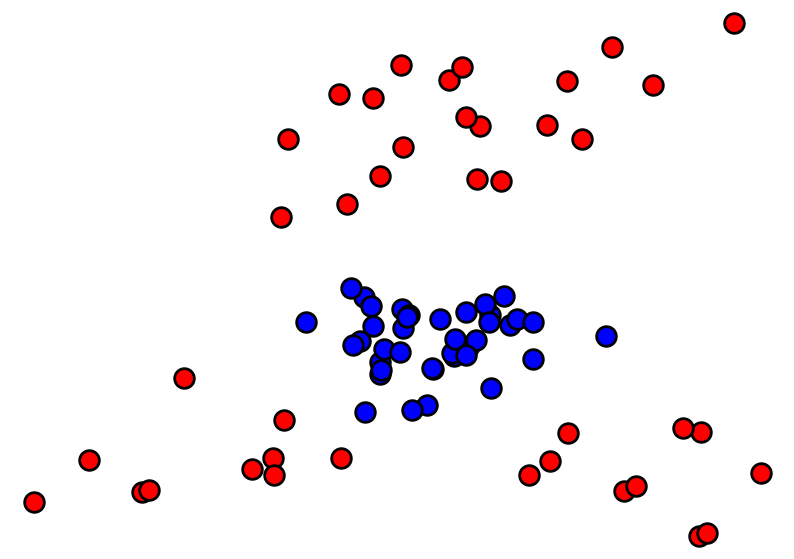

In [64]:
plt.figure(figsize = (10,7))
plt.axis('off')
myplot(X[0,:],X[1,:],10,'b')
myplot(Y[0,:],Y[1,:],10,'r')
plt.xlim(np.min(Y[0,:])-.1,np.max(Y[0,:])+.1)
plt.ylim(np.min(Y[1,:])-.1,np.max(Y[1,:])+.1)
plt.show()

Solve the optimal transport.

In [66]:
P = cp.Variable((n,m))
constraints = [
    0 <= P,
    cp.sum(P, axis=1, keepdims=True) == a,  # Row sums = a
    cp.sum(P, axis=0, keepdims=True).T == b  # Column sums = b
]
objective = cp.Minimize( cp.sum(cp.multiply(P,C)) )
prob = cp.Problem(objective, constraints)
result = prob.solve()

Show that $P$ is a binary permutation matrix.

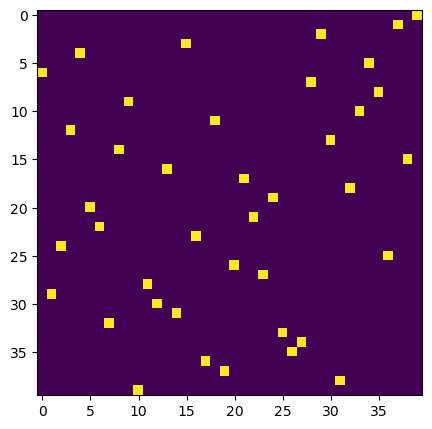

In [67]:
plt.figure(figsize = (5,5))
plt.imshow(P.value);

Display the optimal assignement.

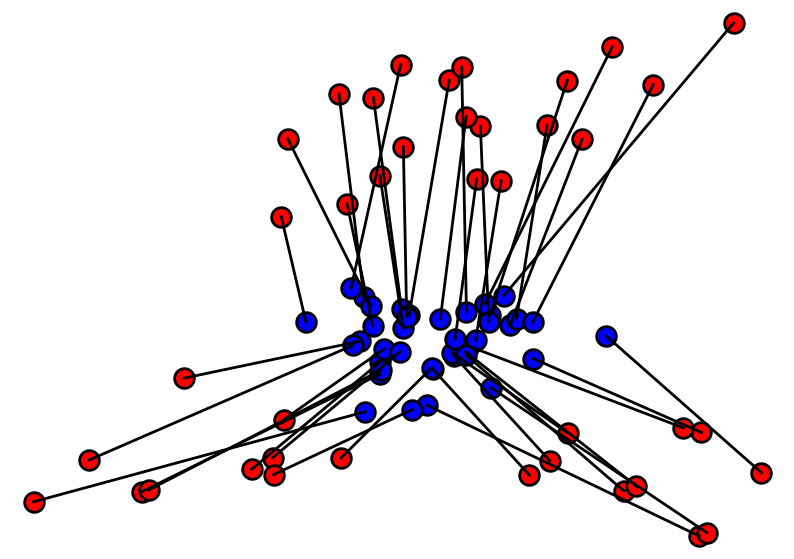

In [68]:
I,J = np.nonzero(P.value>1e-5)
plt.figure(figsize = (10,7))
plt.axis('off')
for k in range(len(I)):
    h = plt.plot(np.hstack((X[0,I[k]],Y[0,J[k]])),np.hstack(([X[1,I[k]], Y[1,J[k]]])),'k', lw = 2)
myplot(X[0,:], X[1,:], 10, 'b')
myplot(Y[0,:], Y[1,:], 10, 'r')
plt.xlim(np.min(Y[0,:])-.1,np.max(Y[0,:])+.1)
plt.ylim(np.min(Y[1,:])-.1,np.max(Y[1,:])+.1)
plt.show()